In [1]:
from pyhdf.SD import SD, SDC


In [2]:
import os


In [3]:
os.chdir('/work/bb1036/b381362/dataset')
modis_file = 'MYD021KM.A2013122.1140.061.2018046032403.hdf'

file = SD(modis_file, SDC.READ)


In [4]:
print(file.info())

datasets_dic = file.datasets()


(31, 58)


In [5]:
for idx, sds in enumerate(datasets_dic.keys()):
    print(idx, sds)


0 Latitude
1 Longitude
2 EV_1KM_RefSB
3 EV_1KM_RefSB_Uncert_Indexes
4 EV_1KM_Emissive
5 EV_1KM_Emissive_Uncert_Indexes
6 EV_250_Aggr1km_RefSB
7 EV_250_Aggr1km_RefSB_Uncert_Indexes
8 EV_250_Aggr1km_RefSB_Samples_Used
9 EV_500_Aggr1km_RefSB
10 EV_500_Aggr1km_RefSB_Uncert_Indexes
11 EV_500_Aggr1km_RefSB_Samples_Used
12 Height
13 SensorZenith
14 SensorAzimuth
15 Range
16 SolarZenith
17 SolarAzimuth
18 gflags
19 EV_Band26
20 EV_Band26_Uncert_Indexes
21 Band_250M
22 Band_500M
23 Band_1KM_RefSB
24 Band_1KM_Emissive
25 Noise in Thermal Detectors
26 Change in relative responses of thermal detectors
27 DC Restore Change for Thermal Bands
28 DC Restore Change for Reflective 250m Bands
29 DC Restore Change for Reflective 500m Bands
30 DC Restore Change for Reflective 1km Bands


In [6]:
sds_obj = file.select('EV_1KM_RefSB')

data = sds_obj.get()

print(data)
print(data.shape)
print(sds_obj.attributes())



[[[13431 13456 13508 ... 11088 11092 11116]
  [13412 13420 13482 ... 11071 11089 11107]
  [13417 13443 13469 ... 11071 11076 11087]
  ...
  [11087 11188 11224 ... 19808 20162 20530]
  [11156 11127 11135 ... 20812 20198 21238]
  [11296 11322 11229 ... 21135 20966 22365]]

 [[19908 19906 20037 ... 17299 17310 17359]
  [19843 19866 19931 ... 17309 17320 17339]
  [19854 19878 19918 ... 17287 17329 17348]
  ...
  [16295 16534 16592 ... 65533 65533 65533]
  [16432 16404 16402 ... 65533 65533 65533]
  [16665 16723 16499 ... 65533 65533 65533]]

 [[23400 23431 23588 ... 20705 20720 20774]
  [23318 23349 23436 ... 20710 20695 20694]
  [23363 23363 23394 ... 20629 20691 20675]
  ...
  [18949 19438 19510 ... 65533 65533 65533]
  [19146 19106 19090 ... 65533 65533 65533]
  [19503 19631 19230 ... 65533 65533 65533]]

 ...

 [[  731   723   723 ...   846   846   846]
  [  736   728   720 ...   844   844   844]
  [  731   731   731 ...   839   839   847]
  ...
  [ 2107  1953  2177 ...  3975  4118  43

In [16]:
import numpy as np
selected_sds = file.select('EV_500_Aggr1km_RefSB')
sds_data_250_Aggr1km_RefSB = selected_sds.get()

selected_sds_attributes = selected_sds.attributes()

for key, value in selected_sds_attributes.items():
	#print key, value
	if key == 'reflectance_scales':
		reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)		
	if key == 'reflectance_offsets':
		reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)	

sds_data_250_Aggr1km_RefSB = selected_sds.get()

print('sds_data shape', sds_data_250_Aggr1km_RefSB.shape)
print(reflectance_scales_250_Aggr1km_RefSB.shape)

selected_sds = file.select('EV_500_Aggr1km_RefSB')

selected_sds_attributes = selected_sds.attributes()

for key, value in selected_sds_attributes.items():
	if key == 'reflectance_scales':
		reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)	
	if key == 'reflectance_offsets':
		reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)	

sds_data_500_Aggr1km_RefSB = selected_sds.get()

print( reflectance_scales_500_Aggr1km_RefSB.shape)



data_shape = sds_data_250_Aggr1km_RefSB.shape

along_track = data_shape[1]
cross_trak = data_shape[2]

z = np.zeros((along_track, cross_trak,3))

z[:,:,0] = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
z[:,:,1] = ( sds_data_500_Aggr1km_RefSB[1,:,:] - reflectance_offsets_500_Aggr1km_RefSB[1] ) * reflectance_scales_500_Aggr1km_RefSB[1] 
z[:,:,2] = ( sds_data_500_Aggr1km_RefSB[0,:,:] - reflectance_offsets_500_Aggr1km_RefSB[0] ) * reflectance_scales_500_Aggr1km_RefSB[0]
norme = 0.4 # factor to increase the brightness ]0,1]

rgb = np.zeros((along_track, cross_trak,3))

rgb = z / norme

rgb[ rgb > 1 ] = 1.0
rgb[ rgb < 0 ] = 0.0


sds_data shape (5, 2030, 1354)
(5,)
(5,)


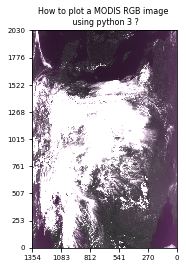

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(111)

img = plt.imshow(np.fliplr(rgb), interpolation='nearest', origin='lower')

l = [int(i) for i in np.linspace(0,cross_trak,6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=7 )

l = [int(i) for i in np.linspace(0,along_track,9)]
plt.yticks(l, l, rotation=0, fontsize=7 )

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.title('How to plot a MODIS RGB image \n using python 3 ?', fontsize=8)

plt.savefig("modis_granule_rgb.png", bbox_inches='tight', dpi=100)

#plt.show()


In [9]:
!ncdump -h '/work/bb1036/b381362/dataset/MYD021KM.A2013122.1140.061.2018046032403.hdf'

netcdf MYD021KM.A2013122.1140.061.2018046032403 {
dimensions:
	\2\*nscans\:MODIS_SWATH_Type_L1B = 406 ;
	\1KM_geo_dim\:MODIS_SWATH_Type_L1B = 271 ;
	Band_1KM_RefSB\:MODIS_SWATH_Type_L1B = 15 ;
	\10\*nscans\:MODIS_SWATH_Type_L1B = 2030 ;
	Max_EV_frames\:MODIS_SWATH_Type_L1B = 1354 ;
	Band_1KM_Emissive\:MODIS_SWATH_Type_L1B = 16 ;
	Band_250M\:MODIS_SWATH_Type_L1B = 2 ;
	Band_500M\:MODIS_SWATH_Type_L1B = 5 ;
	Band_250M = 2 ;
	Band_500M = 5 ;
	Band_1KM_RefSB = 15 ;
	Band_1KM_Emissive = 16 ;
	number\ of\ emissive\ bands = 16 ;
	detectors\ per\ 1km\ band = 10 ;
	number\ of\ scans = 203 ;
	number\ of\ 250m\ bands = 2 ;
	detectors\ per\ 250m\ band = 40 ;
	number\ of\ 500m\ bands = 5 ;
	detectors\ per\ 500m\ band = 20 ;
	number\ of\ 1km\ reflective\ bands = 15 ;
variables:
	float Latitude(\2\*nscans\:MODIS_SWATH_Type_L1B, \1KM_geo_dim\:MODIS_SWATH_Type_L1B) ;
		Latitude:units = "degrees" ;
		Latitude:valid_range = -90.f, 90.f ;
		Latitude:_FillValue = -999.f ;
		Latitude:line_numbers = "3,8" ;
